## Classification


# **Sylvie Fortier**

# Setup

In [1]:
# For consistency in graphs throughout the notebook
import numpy as np
import pandas as pd

# For consistency in figures throughout the notebook
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Make this notebook's output stable across runs
np.random.seed(123)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 1) Select Performance Measures

A common way to evaluate a model is to look at the accuracy of the model. However, accuracy is generally not the preferred performance measure for classifiers, especially with skewed data in a dataset (i.e., when some classes are much more frequent than others).

A good way to evaluation model performance is to use cross-validation along with other performance measures such as Precision and Recall, F1 score, and computing the ROC AUC. 

As a rule of thumb, the Precision and Recall (F1 score) is prefered whenever the positive class "1" is rare or when the false positives are more important than the false negatives, and the ROC AUC is prefered otherwise.

Since our dataset is not nicely balanced, and the positive class "1" is more rare, we will look at all performance measures but will prefer the F1 score over accuracy and ROC AUC to choose the best model and the best threshold.

# 2) Data Inspection and Cleaning

In [2]:
# Read Excel data file
df = pd.read_excel('default of credit card clients.xls', sheet_name=0, skiprows=1, header=0, index_col=0, dtype=np.int32)

In [4]:
# Check at a random sample of the DF
df.sample(n=5)
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
ID         ...                                                                  
1      -2  ...          0          0          0         0       689         0   
2       0  ...       3272       3455       3261         0      1000      1000   
3       0  ...      14331      14948      15549      1518      1500      1000   
4       0  ...      28314      28959      29547      2000      2019      1200   
5       0  ...      20940      19146      19131      2000     36681     10000   

    PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
ID                                                            
1          0         0         0                           1  
2       1000         0      2000                           1  
3       1000      1000      5000                           0  
4       1100      1069      1000                           0  
5       9000       689       679                           0  

[5 rows x 24 columns]

In [5]:
# Check number of observations and columns
df.shape

(30000, 24)

**Notes:**
- 30k observations
- 1x DV/Target
- 23x features

In [6]:
# Check for data types
df.dtypes

LIMIT_BAL                     int32
SEX                           int32
EDUCATION                     int32
MARRIAGE                      int32
AGE                           int32
PAY_0                         int32
PAY_2                         int32
PAY_3                         int32
PAY_4                         int32
PAY_5                         int32
PAY_6                         int32
BILL_AMT1                     int32
BILL_AMT2                     int32
BILL_AMT3                     int32
BILL_AMT4                     int32
BILL_AMT5                     int32
BILL_AMT6                     int32
PAY_AMT1                      int32
PAY_AMT2                      int32
PAY_AMT3                      int32
PAY_AMT4                      int32
PAY_AMT5                      int32
PAY_AMT6                      int32
default payment next month    int32
dtype: object

In [7]:
# Rename columns for ease of use
df.columns = ['Limit', 'Sex', 'Education', 'Marriage', 'Age', \
              'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6', \
              'Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', \
              'PPay_amt1', 'PPay_amt2', 'PPay_amt3','PPay_amt4', 'PPay_amt5', 'PPay_amt6', \
              'Target']

In [8]:
# Rearrange columns 
df = df[['Target', 'Sex', 'Education', 'Marriage', \
         'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6', \
         'Age', 'Limit', \
         'Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', \
         'PPay_amt1', 'PPay_amt2', 'PPay_amt3','PPay_amt4', 'PPay_amt5', 'PPay_amt6']]

In [9]:
# Check for duplicates
df.duplicated().any()

True

In [10]:
# Remove duplicates
df.drop_duplicates(inplace=True)
df.shape

(29965, 24)

In [5]:
# Check for missing values
df.isnull().sum().any()

False

## Sort features by type of variables

In [12]:
# List of all features
features = [col for col in df.columns if col != 'Target']

# List of categorical features
cat_features = ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6']

# List of numerical features
num_features = [col for col in features if col not in cat_features]

print(f"Categorical features >>> {cat_features}")
print(f"Numerical features >>> {num_features}")
print(f"All features >>> {features}")

Categorical features >>> ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6']
Numerical features >>> ['Age', 'Limit', 'Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2', 'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6']
All features >>> ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6', 'Age', 'Limit', 'Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2', 'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6']


# 3) Data Exploration and Cleaning

In [13]:
# Conduct univariate descriptive analysis on the entire dataset
df.describe()

Target           Sex     Education      Marriage        PPay_1  \
count  29965.000000  29965.000000  29965.000000  29965.000000  29965.000000   
mean       0.221258      1.603738      1.853629      1.551877     -0.016753   
std        0.415101      0.489128      0.790411      0.521997      1.123492   
min        0.000000      1.000000      0.000000      0.000000     -2.000000   
25%        0.000000      1.000000      1.000000      1.000000     -1.000000   
50%        0.000000      2.000000      2.000000      2.000000      0.000000   
75%        0.000000      2.000000      2.000000      2.000000      0.000000   
max        1.000000      2.000000      6.000000      3.000000      8.000000   

             PPay_2        PPay_3        PPay_4        PPay_5        PPay_6  \
count  29965.000000  29965.000000  29965.000000  29965.000000  29965.000000   
mean      -0.131854     -0.164392     -0.218922     -0.264509     -0.289438   
std        1.196322      1.195878      1.168175      1.132220      1.149090   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

       ...        Bill_3         Bill_4         Bill_5         Bill_6  \
count  ...  2.996500e+04   29965.000000   29965.000000   29965.000000   
mean   ...  4.706792e+04   43313.329885   40358.334390   38917.012281   
std    ...  6.937135e+04   64353.514373   60817.130623   59574.147742   
min    ... -1.572640e+05 -170000.000000  -81334.000000 -339603.000000   
25%    ...  2.711000e+03    2360.000000    1787.000000    1262.000000   
50%    ...  2.013500e+04   19081.000000   18130.000000   17124.000000   
75%    ...  6.020100e+04   54601.000000   50247.000000   49252.000000   
max    ...  1.664089e+06  891586.000000  927171.000000  961664.000000   

           PPay_amt1     PPay_amt2      PPay_amt3      PPay_amt4  \
count   29965.000000  2.996500e+04   29965.000000   29965.000000   
mean     5670.099316  5.927983e+03    5231.688837    4831.617454   
std     16571.849467  2.305346e+04   17616.361124   15674.464538   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1000.000000  8.500000e+02     390.000000     300.000000   
50%      2102.000000  2.010000e+03    1804.000000    1500.000000   
75%      5008.000000  5.000000e+03    4512.000000    4016.000000   
max    873552.000000  1.684259e+06  896040.000000  621000.000000   

           PPay_amt5      PPay_amt6  
count   29965.000000   29965.000000  
mean     4804.897047    5221.498014  
std     15286.372298   17786.976864  
min         0.000000       0.000000  
25%       261.000000     131.000000  
50%      1500.000000    1500.000000  
75%      4042.000000    4000.000000  
max    426529.000000  528666.000000  

[8 rows x 24 columns]

**Notes:**<br>
There are some numbers that don't make sense such as minimums and maximums.
Let's keep the following features in mind when looking at their data distributions visually:
- Education
- Marriage
- Bill
- PPay_amt

## Number of observations per group

Target
0         23335
1          6630
dtype: int64

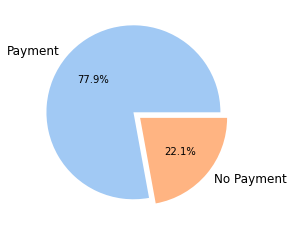

In [14]:
# Define custom function
def check_dataset_balance(series):
    
    # find unique values
    unique = series.value_counts()
    display(unique)
    
    # plot a pie chart to see if data are balanced
    legend=['Payment','No Payment']
    plt.pie(x=unique, explode=[0.05]*len(unique), labels=legend, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.show()
        
# Call the function with series=df.Target
check_dataset_balance(df[['Target']])

**Notes:**<br>
The majority of people pay their CC on time (78%).<br>
Therefore, out dataset is not balanced but acceptable.

## Descriptive analysis per group

In [15]:
'''df.groupby('Target').aggregate(['mean','median', 'std','min','max'])\
    [['Sex', 'Age', 'Education', 'Marriage', 'Balance', \
      'Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', \
      'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6', \
      'PPay_amt1', 'PPay_amt2', 'PPay_amt3','PPay_amt4', 'PPay_amt5', 'PPay_amt6']].T'''

# Display less columns to see some numbers
df.groupby('Target').aggregate(['mean','median', 'std','min','max'])\
    [['Sex', 'Age', 'Education', 'Marriage', 'Limit', \
      'Bill_1', 'Bill_6', 'PPay_1', 'PPay_6', 'PPay_amt1', 'PPay_amt6']].T

Target                         0              1
Sex       mean          1.614099       1.567270
          median        2.000000       2.000000
          std           0.486818       0.495491
          min           1.000000       1.000000
          max           2.000000       2.000000
Age       mean         35.421041      35.723529
          median       34.000000      34.000000
          std           9.078735       9.695564
          min          21.000000      21.000000
          max          79.000000      75.000000
Education mean          1.841826       1.895173
          median        2.000000       2.000000
          std           0.806865       0.728091
          min           0.000000       1.000000
          max           6.000000       6.000000
Marriage  mean          1.558560       1.528356
          median        2.000000       2.000000
          std           0.520832       0.525438
          min           0.000000       0.000000
          max           3.000000       3.000000
Limit     mean     178084.508249  129984.567119
          median   150000.000000   90000.000000
          std      131665.894718  115258.618215
          min       10000.000000   10000.000000
          max     1000000.000000  740000.000000
Bill_1    mean      52058.720249   48552.813122
          median    23242.000000   20209.500000
          std       73600.551468   73801.169840
          min     -165580.000000   -6676.000000
          max      964511.000000  613860.000000
Bill_6    mean      39090.665395   38305.821418
          median    16710.000000   18039.500000
          std       59568.168589   59595.656206
          min     -209051.000000 -339603.000000
          max      961664.000000  514975.000000
PPay_1    mean         -0.211356       0.668175
          median        0.000000       1.000000
          std           0.951863       1.383369
          min          -2.000000      -2.000000
          max           8.000000       8.000000
PPay_6    mean         -0.403814       0.113122
          median        0.000000       0.000000
          std           1.005169       1.484529
          min          -2.000000      -2.000000
          max           7.000000       8.000000
PPay_amt1 mean       6315.052111    3400.118401
          median     2474.000000    1641.000000
          std       18024.366740    9548.023320
          min           0.000000       0.000000
          max      873552.000000  300000.000000
PPay_amt6 mean       5726.355817    3444.596531
          median     1710.000000    1000.000000
          std       18803.577136   13469.699461
          min           0.000000       0.000000
          max      528666.000000  345293.000000

**Note:**<br>
Not obvious differences so far between groups. However we can see that some data are heavily skewed. We'll check for that visually next.

## Histograms

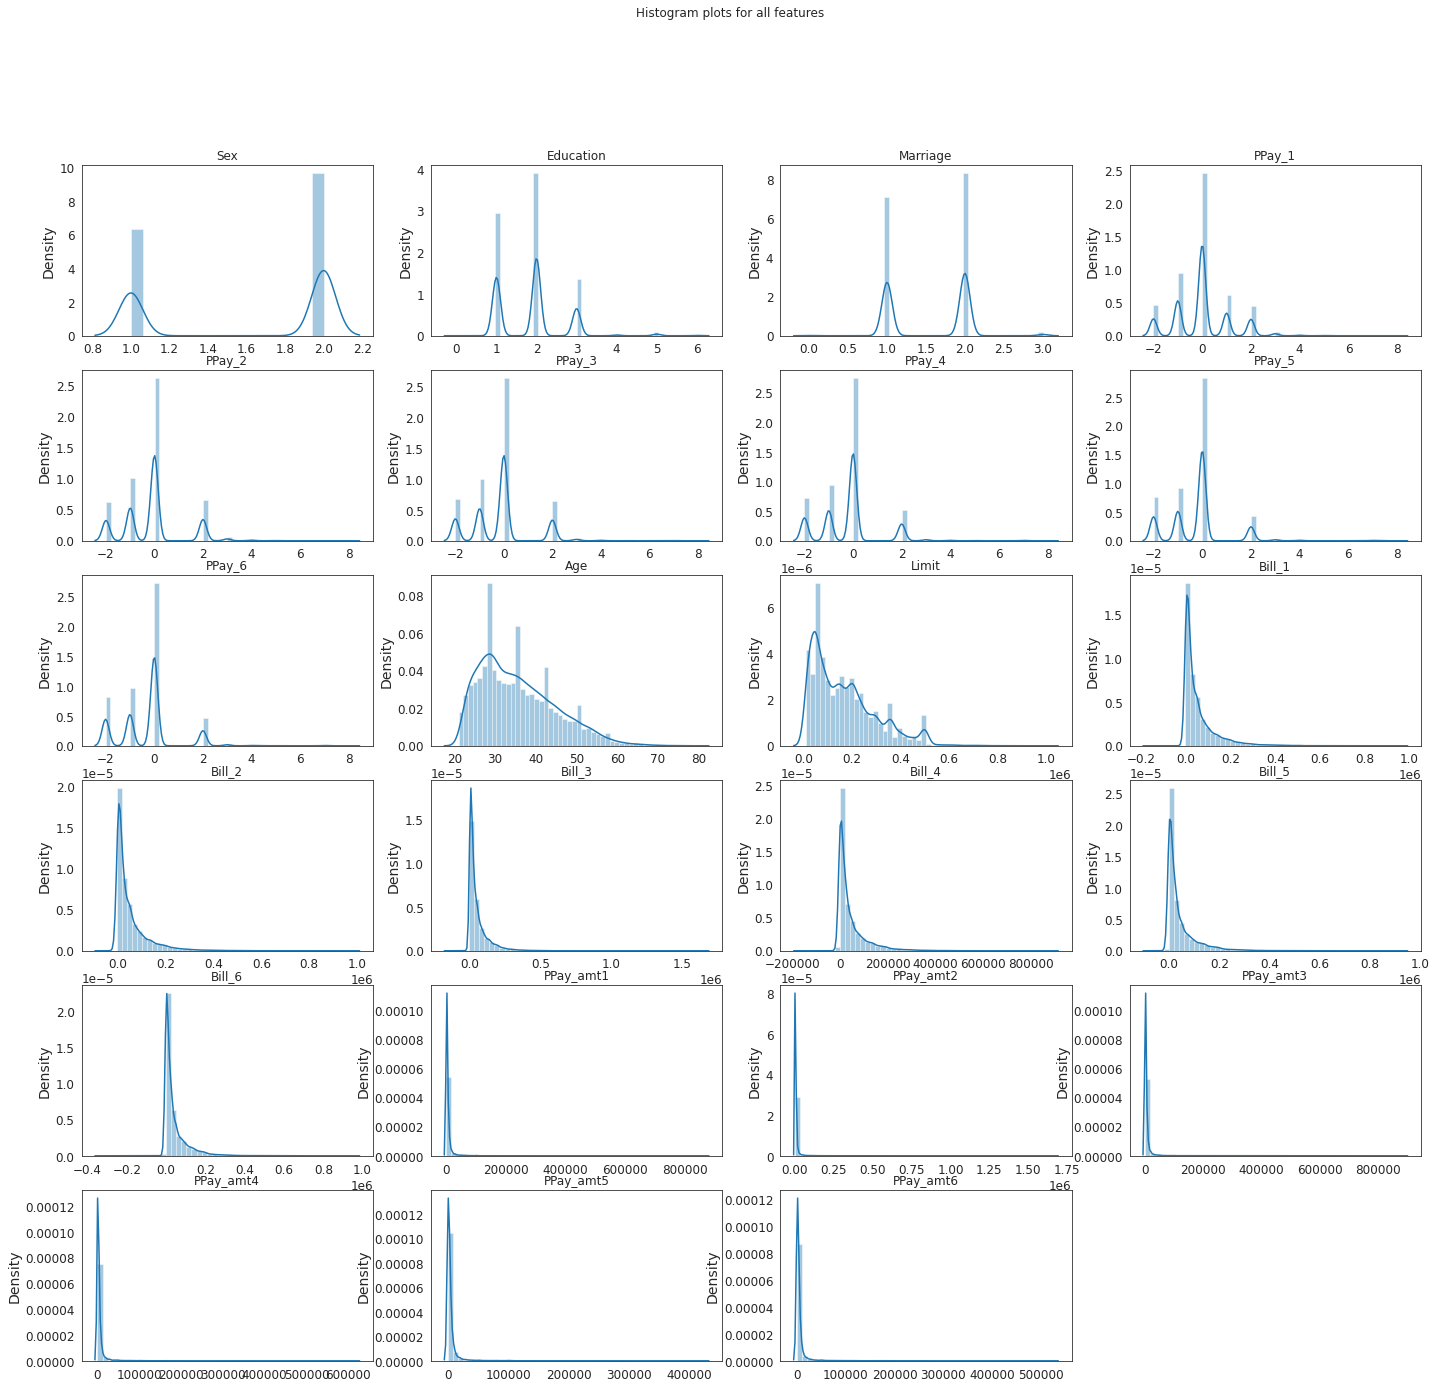

In [16]:
# Plot histograms to look at the distribution for each feature seperately

plt.subplots(figsize=(24,22))
sns.set_style('white')
count=1

for col in df.columns[1:]: # all except Target
    plt.subplot(6,4,count)         
    sns.distplot(x=df[col], hist=True, kde=True)
    plt.title(col)
    count+=1

plt.suptitle('Histogram plots for all features')
plt.show()

**Notes:**<br>
The dataset needs a lot of data processing to clean up the majority of the features:<br>

a) Invalid data for:
- Education >> range s/b (1-4)
- Marriage >> range s/b (1-3)

b) Skewed data for all num_features:
- Age
- Limit
- Bill_1to6
- PPay_amt_1to6

c) Possible outliers for:
- Limit
- Bill_1to6
- PPay_amt_1to6

## Invalid data

It was found that Education and Marriage have values outside the possible range. Let's deal with each of them separately.

**(i) Education**

Possible values for Education are 1 = graduate school; 2 = university; 3 = high school; or 4 = others <br>
Therefore, all values outside the range (1-4) are considered invalid and should be removed.

In [17]:
# How many observations with Education < 1 and > 4
print('Number of observations with Education less than 1 >>>', df[df.Education < 1].shape[0]) # shape[0] = rows 
print('Number of observations with Education greater than 4 >>>', df[df.Education > 4].shape[0])

Number of observations with Education less than 1 >>> 14
Number of observations with Education greater than 4 >>> 331


In [18]:
# Drop invalid observations for Education
df.drop(labels=df[df.Education < 1].index.tolist(), axis=0, inplace=True)
df.drop(labels=df[df.Education > 4].index.tolist(), axis=0, inplace=True)

In [19]:
# Number of observations after dropping invalid Education data
df.shape

(29620, 24)

**(ii) Marriage**

Possible values for Marriage are 1 = married; 2 = single; or 3 = others <br>
Therefore, all values outside the range (1-3) are considered invalid and should be removed.

In [20]:
# How many observations with Marriage < 1 and > 3
print('Number of observations with Marriage less than 1 >>>', df[df.Marriage < 1].shape[0]) # shape[0] = rows 
print('Number of observations with Marriage greater than 3 >>>', df[df.Marriage > 3].shape[0])

Number of observations with Marriage less than 1 >>> 54
Number of observations with Marriage greater than 3 >>> 0


In [21]:
# Drop invalid observations for Marriage
df.drop(labels=df[df.Marriage < 1].index.tolist(), axis=0, inplace=True)

In [22]:
# Number of observations after dropping invalid Education and Marriage data
df.shape

(29566, 24)

In [23]:
# Number of observations and columns for all features
df[features].shape

(29566, 23)

## Data Transformation

Since it was determined earlier that all num_features are skewed, a transformation will be applied to these features in an attempt to normalize them.


Box-Cox and Yeo-Johnson transformations are used to find the most suitable transformation based on the lambda.

    lambda = -1. is a reciprocal transformation
    lambda = -0.5 is a reciprocal square root transformation
    lambda = 0.0 is a log transformation
    lambda = 0.5 is a square root transformation
    lambda = 1.0 is no transformation

Box-Cox requires the input data to be positive <br>
For negative input values, use $stats.yeojohnson()$

First let's divide the num_features into those with positive and those with negative values because different transformation will need to be applied.

**(i) Positive values using Box-Cox transformation**

The optimal lambda for Age is [-0.47832167].


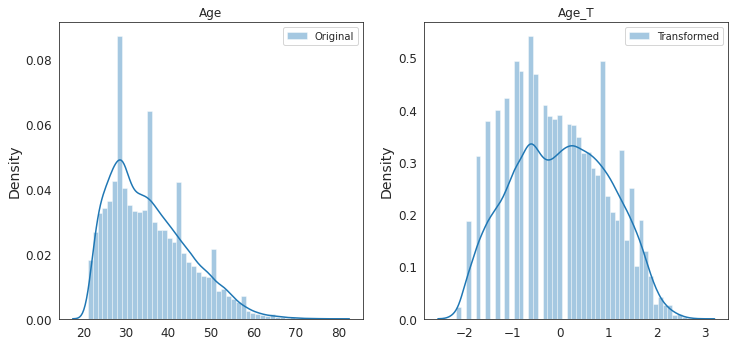

The optimal lambda for Limit is [0.26564281].


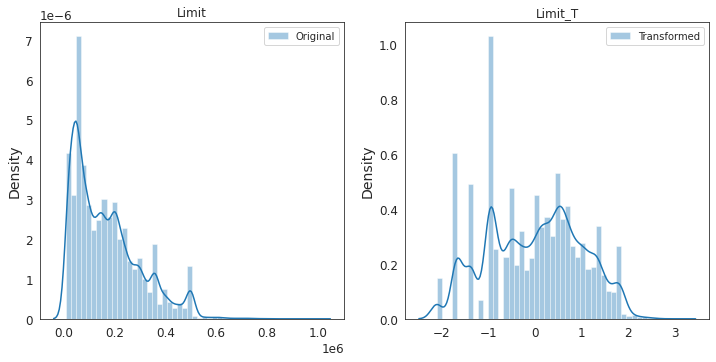

In [24]:
from sklearn.preprocessing import PowerTransformer

# Define which num_features have only positive values with no zeros
num_features_pos = ['Age', 'Limit']

for var in df[num_features_pos]:
    
    # Calculate power
    power = PowerTransformer(method='box-cox', standardize=True)
    
    # Fit
    power.fit(df[num_features_pos][[var]])  
    
    # Print lambda values
    print('The optimal lambda for {} is {}.'.format(var, power.lambdas_))
    
    # Create a new column in DF for each feature
    col_name = var + '_T'
    
    # Transform the data
    df[[col_name]] = power.transform(df[num_features_pos][[var]])
    
    fig = plt.figure(figsize=(12,12))
    count = 1

    # Plot the Original Data
    plt.subplot(2,2,count)
    sns.distplot(df[num_features_pos][[var]], label='Original')
    plt.legend()
    plt.title(var)
    count +=1
 
    # Plot the Transformed Data
    plt.subplot(2,2,count)
    sns.distplot(df[[col_name]], label='Transformed')
    plt.legend()
    plt.title(col_name)
    count +=1

    plt.show() 
    

**(ii) Negative and zeros values using Yeo-Johnson transformation**

Different transformations will be used and we'll keep the one who performed the best.<br>
We'll start using the PowerTransformer for negative values.

In [25]:
# Define which num_features have negative or zeros values
num_features_neg = ['Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2', 'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6']

In [26]:
'''
    >>>>>> THIS CELL IS INACTIVE BECAUSE IT DID NOT PRODUCE THE BEST TRANSFORMATION <<<<<<<
 
for var in df[num_features_neg]:
    
    # Calculate power
    power = PowerTransformer(method='yeo-johnson', standardize=True)
    
    # Fit
    power.fit(df[num_features_neg][[var]]) 
    
    # Print lambda values
    print('The optimal lambda for {} is {}.'.format(var, power.lambdas_))
    
    # Transform the data
    col_name = var + '_YJ'
    df[[col_name]] = power.transform(df[num_features_neg][[var]])
    
    fig = plt.figure(figsize=(10,25))
    count = 1

    # Plot the Original Data
    plt.subplot(12,2,count)
    sns.distplot(df[num_features_neg][[var]], label='Original')
    plt.legend()
    plt.title(var)
    count +=1
 
    # Plot the Transformed Data
    plt.subplot(12,2,count)
    sns.distplot(df[[col_name]], label='Transformed')
    plt.legend()
    plt.title(col_name)
    count +=1

    plt.show() 
'''

"\n    >>>>>> THIS CELL IS INACTIVE BECAUSE IT DID NOT PRODUCE THE BEST TRANSFORMATION <<<<<<<\n \nfor var in df[num_features_neg]:\n    \n    # Calculate power\n    power = PowerTransformer(method='yeo-johnson', standardize=True)\n    \n    # Fit\n    power.fit(df[num_features_neg][[var]]) \n    \n    # Print lambda values\n    print('The optimal lambda for {} is {}.'.format(var, power.lambdas_))\n    \n    # Transform the data\n    col_name = var + '_YJ'\n    df[[col_name]] = power.transform(df[num_features_neg][[var]])\n    \n    fig = plt.figure(figsize=(10,25))\n    count = 1\n\n    # Plot the Original Data\n    plt.subplot(12,2,count)\n    sns.distplot(df[num_features_neg][[var]], label='Original')\n    plt.legend()\n    plt.title(var)\n    count +=1\n \n    # Plot the Transformed Data\n    plt.subplot(12,2,count)\n    sns.distplot(df[[col_name]], label='Transformed')\n    plt.legend()\n    plt.title(col_name)\n    count +=1\n\n    plt.show() \n"

**(iii) Negative values using cube transformation**

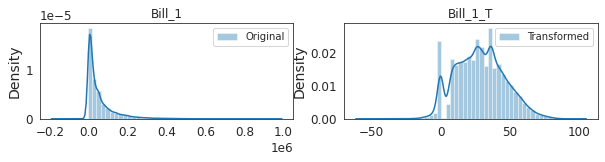

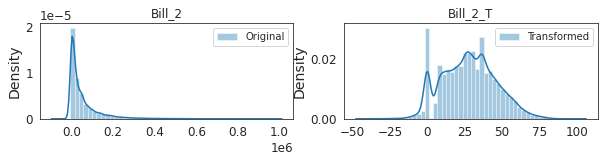

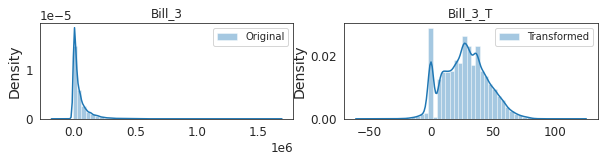

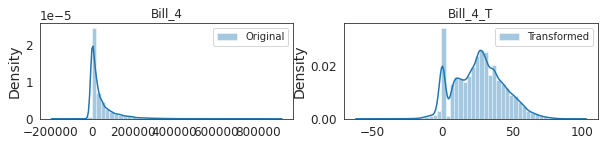

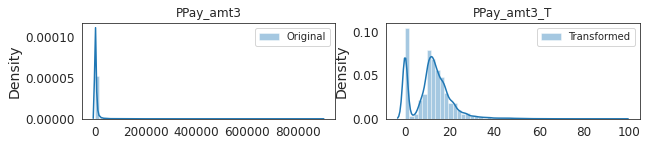

In [27]:
# Define custom function to compute cubic transformation

for var in df[num_features_neg]:
    
  
    # Create a new column in DF for each feature
    col_name = var + '_T'
    
    # Transform the data
    df[[col_name]] = df[num_features_neg][[var]].apply(np.cbrt)
    #df[[col_name]] = df[num_features_neg][[var]]**(1/3)
    
    fig = plt.figure(figsize=(10,25))
    count = 1

    # Plot the Original Data
    plt.subplot(12,2,count)
    sns.distplot(df[num_features_neg][[var]], label='Original')
    plt.legend()
    plt.title(var)
    count +=1
 
    # Plot the Transformed Data
    plt.subplot(12,2,count)
    sns.distplot(df[[col_name]], label='Transformed')
    plt.legend()
    plt.title(col_name)
    count +=1

    plt.show() 


**(iv) Negative values using custom log transformation**

In [28]:
'''

         >>>>>> THIS CELL IS INACTIVE BECAUSE IT DID NOT PRODUCE THE BEST TRANSFORMATION <<<<<<<
 
def my_log(x):
    
    abs_x = np.abs(x)
     
    for abs_x in x:
        if abs_x > 0:
            df[col_name] = ((x/abs_x) * np.log(abs_x))
        else:
            df[col_name] = x

              
    fig = plt.figure(figsize=(10,25))
    count = 1
    
    # Plot the Original Data
    plt.subplot(12,2,count)
    sns.distplot(df[num_features_neg][[var]], label='Original')
    plt.legend()
    plt.title(var)
    count +=1
  
    # Plot the Transformed Data
    plt.subplot(12,2,count)
    sns.distplot(df[col_name], label='custom log')
    plt.legend()
    plt.title(col_name)
    count +=1
    
    plt.show()
'''

"\n\n         >>>>>> THIS CELL IS INACTIVE BECAUSE IT DID NOT PRODUCE THE BEST TRANSFORMATION <<<<<<<\n \ndef my_log(x):\n    \n    abs_x = np.abs(x)\n     \n    for abs_x in x:\n        if abs_x > 0:\n            df[col_name] = ((x/abs_x) * np.log(abs_x))\n        else:\n            df[col_name] = x\n\n              \n    fig = plt.figure(figsize=(10,25))\n    count = 1\n    \n    # Plot the Original Data\n    plt.subplot(12,2,count)\n    sns.distplot(df[num_features_neg][[var]], label='Original')\n    plt.legend()\n    plt.title(var)\n    count +=1\n  \n    # Plot the Transformed Data\n    plt.subplot(12,2,count)\n    sns.distplot(df[col_name], label='custom log')\n    plt.legend()\n    plt.title(col_name)\n    count +=1\n    \n    plt.show()\n"

In [29]:
'''
         >>>>>> THIS CELL IS INACTIVE BECAUSE IT DID NOT PRODUCE THE BEST TRANSFORMATION <<<<<<<
 
num_features_neg = ['Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2', 'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6']
 
for var in df[num_features_neg]:
    # Rename
    col_name = var + '_log'
    
    my_log(df[var])
'''

"\n         >>>>>> THIS CELL IS INACTIVE BECAUSE IT DID NOT PRODUCE THE BEST TRANSFORMATION <<<<<<<\n \nnum_features_neg = ['Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2', 'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6']\n \nfor var in df[num_features_neg]:\n    # Rename\n    col_name = var + '_log'\n    \n    my_log(df[var])\n"

**Action: Re-assign the features**

In [30]:
# List of all features
features = [col for col in df.columns if col != 'Target']

# List of columns to be removed
remove = ['Age', 'Limit', 'Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2', 'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6']

# Keep only columns that are not in the remove list
features = [col for col in df[features].columns if col not in remove]

# List of categorical features
cat_features = ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6']

# List of numerical features
num_features = [col for col in features if col not in cat_features]

print(f"Categorical features >>> {cat_features}")
print(f"Numerical features >>> {num_features}")
print(f"All features >>> {features}")

Categorical features >>> ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6']
Numerical features >>> ['Age_T', 'Limit_T', 'Bill_1_T', 'Bill_2_T', 'Bill_3_T', 'Bill_4_T', 'Bill_5_T', 'Bill_6_T', 'PPay_amt1_T', 'PPay_amt2_T', 'PPay_amt3_T', 'PPay_amt4_T', 'PPay_amt5_T', 'PPay_amt6_T']
All features >>> ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6', 'Age_T', 'Limit_T', 'Bill_1_T', 'Bill_2_T', 'Bill_3_T', 'Bill_4_T', 'Bill_5_T', 'Bill_6_T', 'PPay_amt1_T', 'PPay_amt2_T', 'PPay_amt3_T', 'PPay_amt4_T', 'PPay_amt5_T', 'PPay_amt6_T']


## Outliers

First use boxplot to visually determine if potential outliers exist in the dataset.<br>
Then, we'll use the cutoff threshold of +/- 3 z-score to identify outliers.<br>
Finally, we'll try the winsorize method and pick which method worked best with out data.

In [31]:
# Make a copy to play with outliers
df2 = df.copy()
df2.shape

(29566, 38)

**(i) Boxplot to visually identify potential outliers**

In [32]:

fig = plt.figure(figsize=(20,20))
count = 1

for col in df2[features].columns:
    plt.subplot(6,4,count)
    plt.title(col)
    sns.boxplot(x='Target', y=col, data=df)
    plt.xlabel('')
    count += 1
    
plt.suptitle('Boxplots of all features per group (payment=0, no payment=1)')
plt.show()

**Note:**<br>
We see a lot of potential outliers that could be also invalid values but it's hard to tell at this point. However, we know that Education and PPay are valid data (range between -2 to 9) so I consider they are real data that needs to be kept in the dataset to train the model with these points.

Boxplots clearly desmontrate that outliers seem to exist for Bill_T and PPay_amt_T so we'll look at them next.

**(ii) Check outliers by converting values into z-score where ± 3 std away is considered an outlier**

In [33]:
import scipy.stats as stats

# Calculate z-score
df_z = df2[num_features].apply(lambda x: stats.zscore(x))
z_score = df_z.stack()[(df_z.stack() > 3) | (df_z.stack() < -3)].unstack()

# Display values > 3 or < -3
z_score

Bill_4_T  Bill_5_T  Bill_6_T  PPay_amt3_T  PPay_amt5_T  PPay_amt4_T  \
ID                                                                           
7      3.167925  3.066478   3.03847          NaN          NaN          NaN   
18          NaN       NaN       NaN     3.466743     5.331593          NaN   
34          NaN       NaN       NaN          NaN          NaN     3.442739   
38          NaN -3.245612       NaN          NaN          NaN          NaN   
41     3.403449       NaN       NaN          NaN          NaN     5.263759   
...         ...       ...       ...          ...          ...          ...   
29973       NaN       NaN       NaN          NaN     4.748893          NaN   
29988       NaN       NaN       NaN     3.805202          NaN          NaN   
29989       NaN       NaN       NaN          NaN          NaN          NaN   
29994       NaN       NaN       NaN          NaN          NaN          NaN   
29999       NaN       NaN       NaN          NaN          NaN          NaN   

       PPay_amt6_T  PPay_amt1_T  PPay_amt2_T  Bill_1_T  Bill_2_T  Limit_T  \
ID                                                                          
7              NaN          NaN          NaN       NaN       NaN      NaN   
18             NaN          NaN          NaN       NaN       NaN      NaN   
34             NaN          NaN          NaN       NaN       NaN      NaN   
38             NaN          NaN          NaN       NaN       NaN      NaN   
41             NaN          NaN          NaN       NaN       NaN      NaN   
...            ...          ...          ...       ...       ...      ...   
29973          NaN          NaN          NaN       NaN       NaN      NaN   
29988          NaN          NaN          NaN       NaN       NaN      NaN   
29989          NaN     3.150534          NaN       NaN       NaN      NaN   
29994          NaN          NaN     3.999113       NaN       NaN      NaN   
29999          NaN     3.604388          NaN       NaN       NaN      NaN   

       Bill_3_T  
ID               
7           NaN  
18          NaN  
34          NaN  
38          NaN  
41          NaN  
...         ...  
29973       NaN  
29988       NaN  
29989       NaN  
29994       NaN  
29999       NaN  

[1930 rows x 13 columns]

Indeed, they are outliers in all columns that the boxplot shows.

In [34]:
# Define which features have potential outliers
out_features = ['Bill_1_T', 'Bill_2_T', 'Bill_3_T', 'Bill_4_T', 'Bill_5_T', 'Bill_6_T', 'PPay_amt1_T', 'PPay_amt2_T', 'PPay_amt3_T', 'PPay_amt4_T', 'PPay_amt5_T', 'PPay_amt6_T']

In [35]:
# Add the z-score for each out_features into df

for col in df2[out_features].columns:
    
    # New name
    col_name = col + '_zscore'
    
    # Calculate z-score and add a new column for each feature
    df2[col_name] = stats.zscore(df2[col])

In [36]:
# Ensure columns were added
df2.columns

Index(['Target', 'Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3',
       'PPay_4', 'PPay_5', 'PPay_6', 'Age', 'Limit', 'Bill_1', 'Bill_2',
       'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2',
       'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6', 'Age_T', 'Limit_T',
       'Bill_1_T', 'Bill_2_T', 'Bill_3_T', 'Bill_4_T', 'Bill_5_T', 'Bill_6_T',
       'PPay_amt1_T', 'PPay_amt2_T', 'PPay_amt3_T', 'PPay_amt4_T',
       'PPay_amt5_T', 'PPay_amt6_T', 'Bill_1_T_zscore', 'Bill_2_T_zscore',
       'Bill_3_T_zscore', 'Bill_4_T_zscore', 'Bill_5_T_zscore',
       'Bill_6_T_zscore', 'PPay_amt1_T_zscore', 'PPay_amt2_T_zscore',
       'PPay_amt3_T_zscore', 'PPay_amt4_T_zscore', 'PPay_amt5_T_zscore',
       'PPay_amt6_T_zscore'],
      dtype='object')

In [37]:
# Number of observations before outliers removal
df2[out_features].shape

(29566, 12)

In [38]:
# Remove outliers from z-scores from df2

# Define custom function
def remove_outliers(df, col):
    for i in df.index:
        value = df[col][i]
        if value > 3:
            df.drop([i], axis=0, inplace=True)
        else:
            continue
            

In [39]:
# Call the function to remove outliers

for col in df2.iloc[:, -12:]:
    remove_outliers(df2, col)


In [40]:
# Ensure observations were removed
df2[out_features].shape

(27651, 12)

In [41]:
# Plot out_features after removal of outliers

fig = plt.figure(figsize=(12,12))
count = 1 

for col in df2[out_features].columns:
    plt.subplot(4,3,count)
    plt.title(col)
    sns.boxplot(x='Target', y=col, data=df2)
    plt.xlabel('')
    count += 1

**Note:**<br>

Definitively looking much better but we should try another method in case it could be better.

**(iii) Winsorizing Transformation**<br>

Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers.

A typical strategy is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Winsorized estimators are usually more robust to outliers than their more standard forms.

In [43]:
# Make a copy to play with outliers
df3 = df.copy()
df3.shape

(29566, 38)

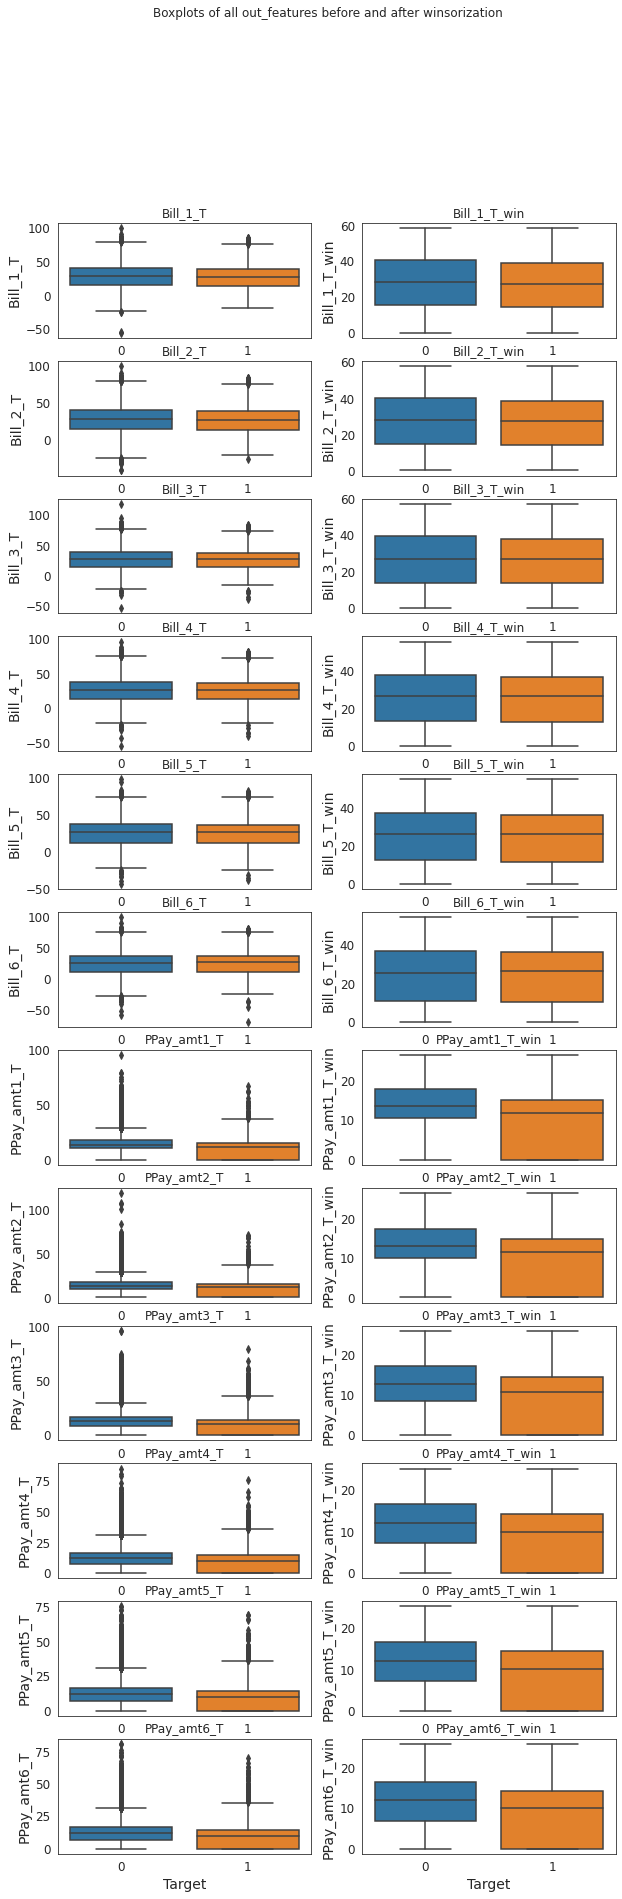

In [44]:
# Define a custom function with 90% winsorization

from scipy.stats.mstats import winsorize


fig = plt.figure(figsize=(10,30))
count = 1

for col in df3[out_features].columns:
    
    # Create new name
    col_name = col + '_win'
    
    # Create new column in DF for winsorized data
    df3[col_name] = winsorize(df3[col], limits=[0.05, 0.05], nan_policy='omit')
        
    # Plot the Original Data
    plt.subplot(12,2,count)
    sns.boxplot(x='Target', y=col, data=df3)
    plt.title(col)
    count +=1
    
    # Plot the Winsorized Data
    plt.subplot(12,2,count)
    sns.boxplot(x='Target', y=col_name, data=df3)
    plt.title(col_name)
    count +=1
    
plt.suptitle('Boxplots of all out_features before and after winsorization')
plt.show()

In [45]:
# Look at distribution before transformation
df3[out_features].quantile([0, 0.05, 0.95, 1]) # Return values at a specific given quantile

Bill_1_T   Bill_2_T    Bill_3_T   Bill_4_T   Bill_5_T   Bill_6_T  \
0.00 -54.912257 -41.169042  -53.977128 -55.396583 -43.326876 -69.768144   
0.05   0.000000   0.000000    0.000000   0.000000   0.000000   0.000000   
0.95  58.537804  57.920174   57.178878  55.845984  54.936400  54.509411   
1.00  98.802757  99.461472  118.501955  96.247121  97.510926  98.705447   

      PPay_amt1_T  PPay_amt2_T  PPay_amt3_T  PPay_amt4_T  PPay_amt5_T  \
0.00     0.000000     0.000000     0.000000     0.000000     0.000000   
0.05     0.000000     0.000000     0.000000     0.000000     0.000000   
0.95    26.400122    26.681441    25.916148    25.217699    25.206555   
1.00    95.593770   118.978811    96.407125    85.316009    75.274785   

      PPay_amt6_T  
0.00     0.000000  
0.05     0.000000  
0.95    25.880492  
1.00    80.858769

In [46]:
# Look at distribution after transformation
df3.iloc[:, -12:].quantile([0, 0.05, 0.95, 1])

Bill_1_T_win  Bill_2_T_win  Bill_3_T_win  Bill_4_T_win  Bill_5_T_win  \
0.00      0.000000      0.000000      0.000000      0.000000      0.000000   
0.05      0.000000      0.000000      0.000000      0.000000      0.000000   
0.95     58.537804     57.920174     57.178878     55.845984     54.936400   
1.00     58.538096     57.920323     57.180815     55.847908     54.936566   

      Bill_6_T_win  PPay_amt1_T_win  PPay_amt2_T_win  PPay_amt3_T_win  \
0.00      0.000000         0.000000         0.000000         0.000000   
0.05      0.000000         0.000000         0.000000         0.000000   
0.95     54.509411        26.400122        26.681441        25.916148   
1.00     54.510365        26.400122        26.682612        25.919872   

      PPay_amt4_T_win  PPay_amt5_T_win  PPay_amt6_T_win  
0.00         0.000000         0.000000         0.000000  
0.05         0.000000         0.000000         0.000000  
0.95        25.217699        25.206555        25.880492  
1.00        25.218354        25.206818        25.881114

In [47]:
# Make sure no observations were dropped
df3.shape

(29566, 50)

**Note:**<br>
As expected, all the negative values haven been replaced by zeros which was the lower 5% before transformation and all extreme values have been replaced by 95th percentile.

The boxplots look better than after removing outliers using the z-score so we will keep this method of dealing with outliers over the z-scores for this dataset.

**Look at the final results with both techniques and decide which technique is best to use with this dataset.**

In [48]:
# Create subplot figure with having two side by side plots
fig, axes = plt.subplots(nrows=12,ncols=2,figsize=(10,30))

# Plot after removal of outliers based on z-scores
df2.iloc[:,26:38].plot(ax = axes[:,0],subplots=True, kind='box') 

# Plot after transformation with winsorize technique
df3.iloc[:,-12:].plot(ax = axes[:,1],subplots=True, kind='box')

plt.show()

**Note:**<br>
The majority of plots have similar scales so it's easy to compare. The plots on the right look a lot more uniform by the transformation and we didn't have to remove any observations.<br>
Therefore, we'll keep the plots on the right moving forward.

**Assign df3 back to df**

Since outliers transformation was a better technique than removing outliers manually, we will re-name df3 to df.

In [49]:
# Assign df3 back to df
df = df3.copy()
df.shape

(29566, 50)

In [50]:
df.columns

Index(['Target', 'Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3',
       'PPay_4', 'PPay_5', 'PPay_6', 'Age', 'Limit', 'Bill_1', 'Bill_2',
       'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 'PPay_amt1', 'PPay_amt2',
       'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6', 'Age_T', 'Limit_T',
       'Bill_1_T', 'Bill_2_T', 'Bill_3_T', 'Bill_4_T', 'Bill_5_T', 'Bill_6_T',
       'PPay_amt1_T', 'PPay_amt2_T', 'PPay_amt3_T', 'PPay_amt4_T',
       'PPay_amt5_T', 'PPay_amt6_T', 'Bill_1_T_win', 'Bill_2_T_win',
       'Bill_3_T_win', 'Bill_4_T_win', 'Bill_5_T_win', 'Bill_6_T_win',
       'PPay_amt1_T_win', 'PPay_amt2_T_win', 'PPay_amt3_T_win',
       'PPay_amt4_T_win', 'PPay_amt5_T_win', 'PPay_amt6_T_win'],
      dtype='object')

**Action: Re-assign the features**

In [52]:
# List of all features
features = [col for col in df.columns if col != 'Target']

# List of columns to be removed
remove = ['Age', 'Limit', 'Bill_1', 'Bill_2', 'Bill_3', 'Bill_4', 'Bill_5', 'Bill_6', 
          'PPay_amt1', 'PPay_amt2', 'PPay_amt3', 'PPay_amt4', 'PPay_amt5', 'PPay_amt6',
          'Bill_1_T', 'Bill_2_T', 'Bill_3_T', 'Bill_4_T', 'Bill_5_T', 'Bill_6_T',
         'PPay_amt1_T', 'PPay_amt2_T', 'PPay_amt3_T', 'PPay_amt4_T','PPay_amt5_T', 'PPay_amt6_T']

# Keep only columns that are not in the remove list
features = [col for col in df.columns[1:] if col not in remove]

# List of categorical features
cat_features = ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6']

# List of numerical features
num_features = [col for col in features if col not in cat_features]

print(f"Categorical features >>> {cat_features}")
print(f"Numerical features >>> {num_features}")

Categorical features >>> ['Sex', 'Education', 'Marriage', 'PPay_1', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6']
Numerical features >>> ['Age_T', 'Limit_T', 'Bill_1_T_win', 'Bill_2_T_win', 'Bill_3_T_win', 'Bill_4_T_win', 'Bill_5_T_win', 'Bill_6_T_win', 'PPay_amt1_T_win', 'PPay_amt2_T_win', 'PPay_amt3_T_win', 'PPay_amt4_T_win', 'PPay_amt5_T_win', 'PPay_amt6_T_win']


## Correlation Analysis

**(i) Numerical Features**<br>
For a binary categorical variable (y) and a continuous variable we can calculate the **point-biserial correlation coefficient** if the categorical variable has a 0/1-coding for the categories. 

https://help.xlstat.com/s/article/which-statistical-test-should-you-use?language=en_US

In [53]:
# Calculate point-biserial correlation between y and num_features
import scipy.stats as stats

y = df['Target']

for var in df[num_features]:
    x = df[num_features][var]
    corr = stats.pointbiserialr(x, y)
    print(var, round(corr[0],3))

Age_T 0.004
Limit_T -0.172
Bill_1_T_win -0.028
Bill_2_T_win -0.017
Bill_3_T_win -0.015
Bill_4_T_win -0.011
Bill_5_T_win -0.01
Bill_6_T_win -0.004
PPay_amt1_T_win -0.172
PPay_amt2_T_win -0.159
PPay_amt3_T_win -0.144
PPay_amt4_T_win -0.131
PPay_amt5_T_win -0.12
PPay_amt6_T_win -0.123


**Note:**<br>
There is no strong correlation between the Target and any numerical variables.<br>
The strongest correlations are with Limit and PPay_amt but still really weak.

**(ii) Categorical Features**<br>
Chi-Square

In [54]:
from scipy import stats
from scipy.stats import chi2_contingency

In [55]:
for var in cat_features: 
    
    obs = pd.crosstab(index=df.Target, columns=df[var])
    chi2, p, dof, expctd = chi2_contingency(obs)
    print('p-value for {}: {}'.format(var, p))

p-value for Sex: 1.0926416328513604e-11
p-value for Education: 1.43549682347754e-25
p-value for Marriage: 1.5703057278917513e-07
p-value for PPay_1: 0.0
p-value for PPay_2: 0.0
p-value for PPay_3: 0.0
p-value for PPay_4: 0.0
p-value for PPay_5: 0.0
p-value for PPay_6: 0.0


## Pairplot

Let's plot pairplots to see the correlations between the Target and each pair of num_features

Note: we'll plot only 1k observations to ease on the processing time.

In [56]:
# Plot all num_features with the Target as hue

# Only plot a sample of 1k observations to make it faster
sns.pairplot(df.sample(1000), vars=num_features, hue='Target')
plt.show()

"\nsns.pairplot(df.sample(1000), vars=num_features, hue='Target')\nplt.show()\n"

## Barcharts

For categorical variables we will use boxplots.

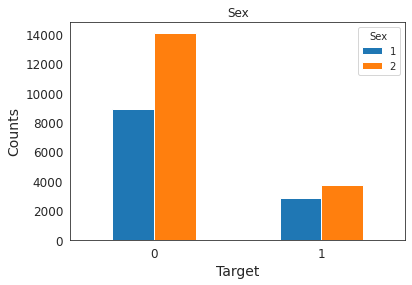

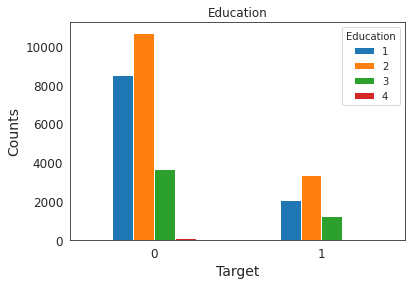

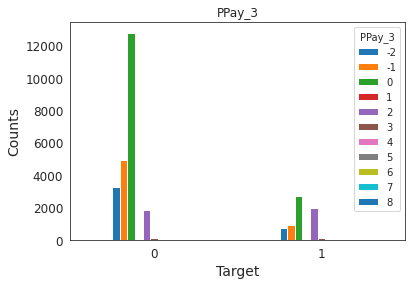

In [57]:
for var in cat_features: 
    
    pd.crosstab(index=df.Target, columns=df[var]).plot(kind='bar', rot=0)
    plt.title(var)
    plt.ylabel('Counts')
    plt.show()    

## Multicollinearity

**(i) Correlation Matrix for num_features**

In [58]:
# Show correlation coefficients (correlation matrix) to check for multicollinearity among numerical features
plt.figure(figsize=(12,12))
sns.heatmap(df[num_features].corr(method='pearson'), annot=True, cmap=sns.cm.vlag)
plt.show()

**Note:**<br>
Strong correlations among numerical features are displayed in red. If we keep all these features, there is a high chance of multicollinearity.<br>
According to the graph above, all Bill_1-6 are strongly correlated and therefore only one of these features should be used in the model.<br>
In addition, PPay_amt1-6 are also correlated but below 0.7. We'll keep that in mind of these end up being important features for the final model.

**(ii) VIF for num_features**

- The Variance Inflation Factor (VIF) measures for how much multicollinearity exists in a regression model. Essentially, it measures for how much regression coefficients are affected by other independent variables in the model. Higher values of Variance Inflation Factor (VIF) are associated with multicollinearity. 
- In other words, it quantifies the severity of multicollinearity among features. It provides an index that measures how much the variance of an estimated regression coefficient is increased because of collinearity. https://en.wikipedia.org/wiki/Variance_inflation_factor
- The generally accepted cutoff for VIF is 10, with higher values denoting levels of multicollinearity that could negatively impact the regression model. However, some authors suggest a more conservative level of 2.5 or above. https://en.wikipedia.org/wiki/Variance_inflation_factor

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get features for which to compute VIF
df2 = df[num_features]

# Add a new column 'Intercept' filled with 1
df2['Intercept'] = 1

# Create empty VIF dataframe
df_vif = pd.DataFrame()

# Add names of features
df_vif['num_features'] = df2.columns

# Add a new column and compute VIF factor
df_vif['VIF factor'] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])] # for all columns including intercept

# View results
df_vif

num_features  VIF factor
0             Age_T    1.040503
1           Limit_T    1.251773
2      Bill_1_T_win    6.404442
3      Bill_2_T_win   13.100076
4      Bill_3_T_win   13.317053
5      Bill_4_T_win   12.971294
6      Bill_5_T_win   12.748644
7      Bill_6_T_win    9.078284
8   PPay_amt1_T_win    2.439340
9   PPay_amt2_T_win    2.530448
10  PPay_amt3_T_win    2.574509
11  PPay_amt4_T_win    2.575227
12  PPay_amt5_T_win    2.647499
13  PPay_amt6_T_win    1.731833
14        Intercept    6.471767

**Note**<br>
Again, Bill_1-6 show potential high multicollinearity because the VIF factors are more than the conservative cutoff of 2.5 for all features.<br>
Consequently, I feel confident that we should only keep Bill_1_T and remove Bill_2-6_T from the list of features.<br>
PPay_amt is borderline but I think we should keep those features for now in the dataset.

**(iii) Cramer's V for cat_features**

Cramer’s V is a statistic measuring the strength of association or dependency between two (nominal) categorical variables.

Cramer’s V correlation coefficient from 0 (corresponding to no association between the variables) to 1 (complete association).

Cramér’s V is an effect size measurement for the chi-square test of independence. It measures how strongly two categorical fields are associated.

        ES ≤ 0.2 >>> The result is weak. Although the result is statistically significant, the fields are only weakly associated.
        0.2 < ES ≤ 0.6 >>> The result is moderate. The fields are moderately associated.
        ES > 0.6 >>> The result is strong. The fields are strongly associated.

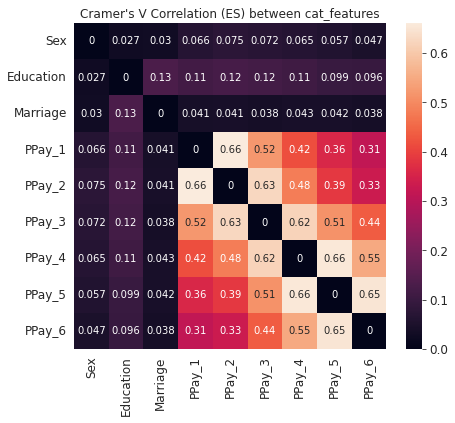

In [60]:
from scipy.stats import chi2_contingency
import scipy.stats as stats
import itertools

# Define custom function to calculate Cramer's V for categorical-categorical association
def cramers_v(x,y):
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Define categorical features
cols = cat_features

corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(df[col1], df[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

# Plot heatmap to show the correlations
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer's V Correlation (ES) between cat_features")
plt.show()

**Note:**<br>
We can see strong effect size (>0.6) among PPay variables. This may cause high chance of multicollinearity in the model and should be removed.<br>
Therefore, we will keep PPay_1 and remove the other ones.

**Action: Removal of features associated with high risk of multicollinearity**

In [61]:
# Remove Bill_2-6 and PPay_2-6 from the list of features

# List of all features
features

# List of columns to be removed
remove = ['Bill_2_T_win', 'Bill_3_T_win', 'Bill_4_T_win', 'Bill_5_T_win', 'Bill_6_T_win', 'PPay_2', 'PPay_3', 'PPay_4', 'PPay_5', 'PPay_6']


features = [col for col in features if col not in remove]

# Keep only features that are not in the remove list
num_features = [x for x in num_features if x not in remove]
cat_features = [x for x in cat_features if x not in remove]

print(f"Categorical features >>> {cat_features}")
print(f"Numerical features >>> {num_features}")
print(f"All features >>> {features}")

Categorical features >>> ['Sex', 'Education', 'Marriage', 'PPay_1']
Numerical features >>> ['Age_T', 'Limit_T', 'Bill_1_T_win', 'PPay_amt1_T_win', 'PPay_amt2_T_win', 'PPay_amt3_T_win', 'PPay_amt4_T_win', 'PPay_amt5_T_win', 'PPay_amt6_T_win']
All features >>> ['Sex', 'Education', 'Marriage', 'PPay_1', 'Age_T', 'Limit_T', 'Bill_1_T_win', 'PPay_amt1_T_win', 'PPay_amt2_T_win', 'PPay_amt3_T_win', 'PPay_amt4_T_win', 'PPay_amt5_T_win', 'PPay_amt6_T_win']


# 4) Select and Train a Model

## Determine X and y

In [62]:
# Define X and y
X = df[features] 
y = df['Target'] 

In [63]:
# Determine number of observations and features for X
X.shape # 

(29566, 13)

## Create train/test sets

Note: You don't want to touch the test set until ready to launch the final model that you're confident about.

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [65]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")

X_train.shape: (23652, 13)
X_test.shape: (5914, 13)
y_train.shape: (23652,)


Note: It's important to have similar proportions of each group/class between the training and test set. Therefore, we'll determine if the dataset was equally split.

0    18373
1     5279
Name: Target, dtype: int64

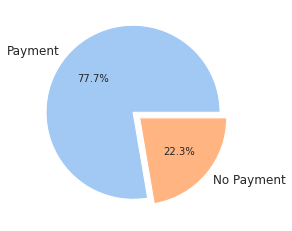

0    4594
1    1320
Name: Target, dtype: int64

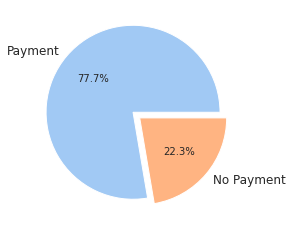

In [66]:
# Verify that the train and test sets are equally split

# Call the function with series=y_train
check_dataset_balance(y_train)

# Call the function with series=y_test
check_dataset_balance(y_test)

## Pipelines

**Transformation pipeline: to clean up and prepare the data for ML.**

Typical transformation pipeline for numerical features are [impute, scale, feature selection], and categorical features are [impute, encode, feature selection] <br>
Since it's safer to apply an imputer because future data migh have missing values after the system goes live, we will add it to the pipeline even though there's currently no missing values in the dataset<br>
Since we are using KNN that is affected by feature scaling, a Scaler will be applied to all numerical features because the range of numbers in the dataset is very large<br>
Scaling the target is generally not required.

In [67]:
# Verify features entering the pipeline

print(f"Categorical features >>> {cat_features}")
print(f"Numerical features >>> {num_features}")

Categorical features >>> ['Sex', 'Education', 'Marriage', 'PPay_1']
Numerical features >>> ['Age_T', 'Limit_T', 'Bill_1_T_win', 'PPay_amt1_T_win', 'PPay_amt2_T_win', 'PPay_amt3_T_win', 'PPay_amt4_T_win', 'PPay_amt5_T_win', 'PPay_amt6_T_win']


In [68]:
# Number of features before the pipeline
X_train.shape

(23652, 13)

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

    
""" As with all the transformation, it's important to fit the scalers to the training set only, not the full dataset."""
""" Correction: tree-based algorithms don't need feature scaling"""


# Numerical features
num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
        ])


# Categorical features
cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(sparse=False))
        ]) 


# Construct full pipeline
full_pipeline = ColumnTransformer([
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features)
        ])

#prep_features = full_pipeline.fit_transform(df[features]) # entire dataset
#full_pipeline.fit_transform(X_train, y_train) train only?

# Apply pipeline to training set
full_pipeline.fit(X_train, y_train)
X_train_trans = full_pipeline.transform(X_train)
print(f"Number of columns after the pipeline (including dummy variables) = {X_train_trans.shape}") # it transforms it into an array 

Number of columns after the pipeline (including dummy variables) = (23652, 29)


## Train the model(s)

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# List of Classifiers to train (2x)
classifiers = [
        KNeighborsClassifier(), # default = n_neighbors=5
        RandomForestClassifier() # default = n_estimators=100
        ]

# Name of Classifiers
classifier_names = ['K-nearest neighbors', 'Random Forest Classifier']

In [71]:
# Train the models using the fit() method with the training set

model_knn = KNeighborsClassifier(n_neighbors=5).fit(X=X_train_trans, y=y_train)
model_rfc = RandomForestClassifier(n_estimators=50, oob_score=True).fit(X=X_train_trans, y=y_train)

# 5) Performance Measures Evaluation

Since you don't want to touch the test set until you're ready to launch a model that you're confident about so you need to use part of the training set for training and part for model validation. Cross-validation does that by training and evaluating the model k times using only the training set by dividing it into folds.

## Cross-Validation

Cross-validation takes a random sample of data points so that if you run it multiple times the performance metrics will be different each time. To get more accurate results, you need to run many iterations and then calculate the average.

In [72]:
from sklearn.model_selection import cross_val_score

# Compute performance data for each Classifier separately
for clf, clf_name in zip(classifiers, classifier_names): 
    
    # Compute the CV score for each Classifier using train set with 5 folds
    cv_scores_acc = cross_val_score(estimator=clf, X=X_train_trans, y=y_train, cv=5, scoring='accuracy')
    cv_scores_f1 = cross_val_score(estimator=clf, X=X_train_trans, y=y_train, cv=5, scoring='f1')
        
    # Display the mean/std for Accuracy for each Classifier
    print(clf_name, '>>> (i) mean accuracy score:', round(cv_scores_acc.mean()*100, 1), '%')
    print(clf_name, '>>> (i) mean F1 score:', round(cv_scores_f1.mean(), 3))


"\n# Compute performance data for each Classifier separately\nfor clf, clf_name in zip(classifiers, classifier_names): \n    \n    # Compute the CV score for each Classifier using train set with 5 folds\n    cv_scores_acc = cross_val_score(estimator=clf, X=X_train_trans, y=y_train, cv=5, scoring='accuracy')\n    cv_scores_f1 = cross_val_score(estimator=clf, X=X_train_trans, y=y_train, cv=5, scoring='f1')\n        \n    # Display the mean/std for Accuracy for each Classifier\n    print(clf_name, '>>> (i) mean accuracy score:', round(cv_scores_acc.mean()*100, 1), '%')\n    print(clf_name, '>>> (i) mean F1 score:', round(cv_scores_f1.mean(), 3))\n    "

Note: so far RandomForest seems to perform slightly better.

## Confusion Matrix

Accuracy for KNeighborsClassifier() >>> 79.4 %
Accuracy for RandomForestClassifier(n_estimators=50, oob_score=True) >>> 81.2 %

KNN:
 [[16871  1502]
 [ 3367  1912]]

RFC:
 [[17421   952]
 [ 3494  1785]]


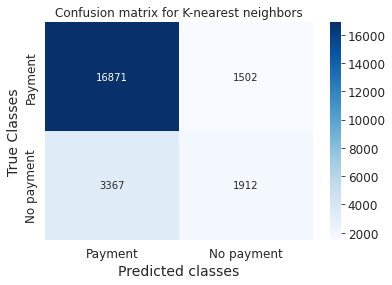

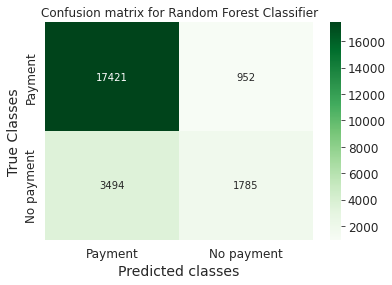

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

# Create predictions (y_hat) using the training set
y_hat_knn_cv = cross_val_predict(model_knn, X_train_trans, y_train, cv=5, method='predict') # Book uses this one
y_hat_rfc_cv = cross_val_predict(model_rfc, X_train_trans, y_train, cv=5, method='predict') # Book uses this one
#y_hat_knn = model_knn.predict() # cannot be used with training set
#y_hat_rfc = model_rfc.predict() # cannot be used with training set


# Display Accuracy(%) using the training set
print('Accuracy for {} >>> {}'.format(model_knn, round(accuracy_score(y_true=y_train, y_pred=y_hat_knn_cv)*100, 1)), '%') 
print('Accuracy for {} >>> {}'.format(model_rfc, round(accuracy_score(y_true=y_train, y_pred=y_hat_rfc_cv)*100, 1)), '%') 


# Confusion Matrix predictions
print('\nKNN:\n', confusion_matrix(y_true=y_train, y_pred=y_hat_knn_cv)) # Book uses this one
print('\nRFC:\n', confusion_matrix(y_true=y_train, y_pred=y_hat_rfc_cv)) # Book uses this one


# Plot Confusion Matrix for KNN using the training set
class_names = ['Payment', 'No payment']
#plot_confusion_matrix() # cannot be used with training set
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=y_hat_knn_cv), annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix for {}'.format(classifier_names[0]))
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()


# Create Confusion Matrix for RFC using the training set
class_names = ['Payment', 'No payment']
#plot_confusion_matrix() # cannot be used with training set
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=y_hat_rfc_cv), annot=True, fmt='g', cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix for {}'.format(classifier_names[1]))
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

## Precision & Recall

In [74]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

# Create predictions (y_hat) using the training set
y_hat_knn_cv = cross_val_predict(model_knn, X_train_trans, y_train, cv=5, method='predict') # Book uses this one

# Precision and Recall for KNN using training set
precision = precision_score(y_true=y_train, y_pred=y_hat_knn_cv) # Book uses this one
recall = recall_score(y_true=y_train, y_pred=y_hat_knn_cv) # Book uses this one
f1 = f1_score(y_true=y_train, y_pred=y_hat_knn_cv) # Book uses this one

# Display results
print('Precision for KNN = %.2f' % precision)
print('Recall for KNN = %.2f' % recall)
print('F1 score for KNN = %.2f' % f1)

Precision for KNN = 0.56
Recall for KNN = 0.36
F1 score for KNN = 0.44


In [75]:
# Precision and Recall for RFC using training set

# Create predictions (y_hat) using the training set
y_hat_rfc_cv = cross_val_predict(model_rfc, X_train_trans, y_train, cv=5, method='predict') # Book uses this one

# Precision and Recall for RFC using training set
precision = precision_score(y_true=y_train, y_pred=y_hat_rfc_cv) # Book uses this one
recall = recall_score(y_true=y_train, y_pred=y_hat_rfc_cv) # Book uses this one
f1 = f1_score(y_true=y_train, y_pred=y_hat_rfc_cv) # Book uses this one

# Display results
print('Precision for RFC = %.2f' % precision)
print('Recall for RFC = %.2f' % recall)
print('F1 score for RFC = %.2f' % f1)

Precision for RFC = 0.65
Recall for RFC = 0.34
F1 score for RFC = 0.45


**(i) Precision-Recall Curve for KNN**

<function matplotlib.pyplot.show(close=None, block=None)>

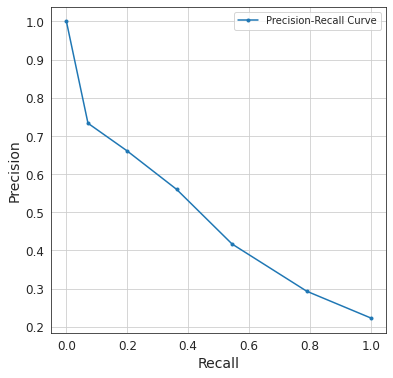

In [76]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities using training set
y_proba = cross_val_predict(model_knn, X_train_trans, y_train, cv=5, method='predict_proba') # Book uses this one
#y_proba = model_knn.predict_proba() # cannot be used with training set

# Determine scores from probabilities
y_score = y_proba[:, 1] # ndarray of shape (rows,)

# Compute Precision-Recall for different threshold values using training set
precision, recall, thresholds = precision_recall_curve(y_true=y_train, probas_pred=y_score) # Book uses this one

# Plot Precision_Recall Curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')

# Settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)   
plt.legend()
plt.show

**(ii) Precision-Recall Curve for RFC**

<function matplotlib.pyplot.show(close=None, block=None)>

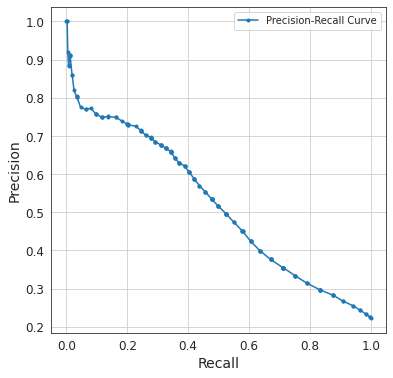

In [77]:
# Predict probabilities using training set
y_proba = cross_val_predict(model_rfc, X_train_trans, y_train, cv=5, method='predict_proba') # Book uses this one
#y_proba = model_rfc.predict_proba() # cannot be used with training set

# Determine scores from probabilities
y_score = y_proba[:, 1] # 1-d

# Compute Precision-Recall for different threshold values using training set
precision, recall, thresholds = precision_recall_curve(y_true=y_train, probas_pred=y_score) # Book uses this one

# Plot Precision_Recall Curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
   
# Settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)   
plt.legend()
plt.show

## ROC Curve

**(i) ROC Curve for both models**

AUC for KNN: 0.70
AUC for RFC: 0.75


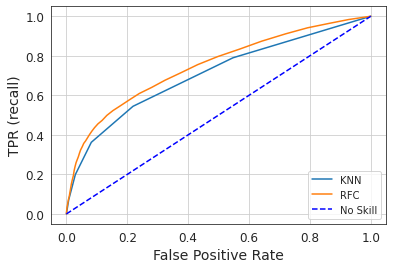

In [78]:
from sklearn.metrics import roc_curve

'''Plot ROC Curve for KNN'''
# Predict probabilities using training set 
y_proba_knn = cross_val_predict(model_knn, X_train_trans, y_train, cv=5, method='predict_proba') # Book uses this one
#y_proba_knn = model_knn.predict_proba() # cannot be used with training set

# Determine scores from probabilities b/c for ROC you need scores, not probabilities
y_score_knn = y_proba_knn[:, 1] # 1-d

# Compute ROC using training set
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_score_knn) # Book uses this one

# Plot ROC Curve
plt.plot(fpr, tpr, label='KNN')



'''Plot ROC Curve for RFC'''
# Predict probabilities using training set 
y_proba_rfc = cross_val_predict(model_rfc, X_train_trans, y_train, cv=5, method='predict_proba') # Book uses this one
#y_proba_knn = model_rfc.predict_proba() # cannot be used with training set

# Determine scores from probabilities b/c for ROC you need scores, not probabilities
y_score_rfc = y_proba_rfc[:, 1] # 1-d

# Compute ROC using test or training set
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_score_rfc) # Book uses this one

# Plot ROC Curve
plt.plot(fpr, tpr, label='RFC')

# Plot no skill in blue
plt.plot([0, 1], [0, 1], linestyle='--', color='b', label='No Skill')

# Settings
plt.xlabel("False Positive Rate")
plt.ylabel("TPR (recall)")
plt.grid(True)
plt.legend(loc=4)
plt.show



# Calculate AUC using the training set
from sklearn.metrics import roc_auc_score

auc_knn = roc_auc_score(y_true=y_train, y_score=y_score_knn) # Book uses this one
auc_rfc = roc_auc_score(y_true=y_train, y_score=y_score_rfc)
print('AUC for KNN: %.2f' % auc_knn)
print('AUC for RFC: %.2f' % auc_rfc)

# 6) Fine-Tune the Final Model

## Hyperparameters Search

Grid search will automatically find out whether or not to add a feature and it may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.

In [79]:
# Define hyperparameters to test
param_knn = {'n_neighbors': [3,5,10,20]}
param_rfc = {'n_estimators': [4,5,10,20,50]} 


""" Below is what was tested including the number of features but
    because it takes 15 minutes to go through all features, I made 
    the code inactive to avoid having to wait that long every time"""
#param_knn = {'n_neighbors': [3,5,10,20]}
#param_rfc = {'n_estimators': [4,5,10,20,50], 'max_features': [i for i in range(2, 29)]} # 29 features after full pipeline


# Pass the model, parameter grid, and cross-validation parameters to the class
from sklearn.model_selection import GridSearchCV
gs_knn = GridSearchCV(model_knn, param_grid=param_knn, cv=5, n_jobs=-1)
gs_rfc = GridSearchCV(model_rfc, param_grid=param_rfc, cv=5, verbose=3, n_jobs=-1)


# Train the models using the train set. This will take a while...
gs_knn.fit(X=X_train_trans, y=y_train) 
gs_rfc.fit(X=X_train_trans, y=y_train)


# Access the best set of parameters
best_params_knn = gs_knn.best_params_
best_params_rfc = gs_rfc.best_params_
print(best_params_knn)
print(best_params_rfc)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'n_neighbors': 20}
{'n_estimators': 50}


Finally...results are in:<br>
- n_neighbors: 20
- n_estimators: 50
- max_features: 9

## Evaluate Performance Measures on Training Set

Evaluate Performance Measures of the final models using training set to compare both final models.

In [80]:
# FINAL MODELS
final_model_knn = gs_knn.best_estimator_
final_model_rfc = gs_rfc.best_estimator_

**(i) Performance comparison between models**

In [81]:
# Print the Performance Measures on Training Set for both Models for comparison
from sklearn.model_selection import cross_val_score

# Accuracy
print(classifiers[0], 'mean Accuracy >>>', round(cross_val_score(final_model_knn, X_train_trans, y_train, cv=5, scoring='accuracy').mean()*100, 2), '%')
print(classifiers[1], 'mean Accuracy >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='accuracy').mean()*100, 2), '%\n')


# Precision
print(classifiers[0], 'mean Precision >>>', round(cross_val_score(final_model_knn, X_train_trans, y_train, cv=5, scoring='precision').mean(), 2))
print(classifiers[1], 'mean Precision >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='precision').mean(), 2),'\n')


# Recall
print(classifiers[0], 'mean Recall >>>', round(cross_val_score(final_model_knn, X_train_trans, y_train, cv=5, scoring='recall').mean(), 2))
print(classifiers[1], 'mean Recall >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='recall').mean(), 2),'\n')


# F1 score
print(classifiers[0], 'mean F1 score >>>', round(cross_val_score(final_model_knn, X_train_trans, y_train, cv=5, scoring='f1').mean(), 2))
print(classifiers[1], 'mean F1 score >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='f1').mean(), 2),'\n')


# ROC AUC
print(classifiers[0], 'mean ROC AUC >>>', round(cross_val_score(final_model_knn, X_train_trans, y_train, cv=5, scoring='roc_auc').mean(), 2))
print(classifiers[1], 'mean ROC AUC >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='roc_auc').mean(), 2))


KNeighborsClassifier() mean Accuracy >>> 81.27 %
RandomForestClassifier() mean Accuracy >>> 81.35 %

KNeighborsClassifier() mean Precision >>> 0.67
RandomForestClassifier() mean Precision >>> 0.65 

KNeighborsClassifier() mean Recall >>> 0.32
RandomForestClassifier() mean Recall >>> 0.34 

KNeighborsClassifier() mean F1 score >>> 0.43
RandomForestClassifier() mean F1 score >>> 0.45 

KNeighborsClassifier() mean ROC AUC >>> 0.74
RandomForestClassifier() mean ROC AUC >>> 0.75


**Note:**<br>

RandomForestClassifier is performing slighly better on all metrics except for precision on the training set <br>
                Therefore **>>> RandomForestClassifier is the chosen model to retain as the final model. <<<**

**(ii) Performance comparison before and after fine-tuning of chosen model**

In [82]:
# Evaluate Performance Measures for RFC before and after fine-tuning using training set.
# Note that both scores should be similar because n_estimators didn't change from before (n=50) but max_features=9 instead of the default=auto
from sklearn.model_selection import cross_val_score

# Accuracy
print('Accuracy_before >>>', round(cross_val_score(model_rfc, X_train_trans, y_train, cv=5, scoring='accuracy').mean()*100, 2), '%')
print('Accuracy_after >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='accuracy').mean()*100, 2), '%\n')


# Precision
print('Precision_before >>>', round(cross_val_score(model_rfc, X_train_trans, y_train, cv=5, scoring='precision').mean(), 3))
print('Precision_after >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='precision').mean(), 3),'\n')


# Recall
print('Recall_before >>>', round(cross_val_score(model_rfc, X_train_trans, y_train, cv=5, scoring='recall').mean(), 3))
print('Recall_after >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='recall').mean(), 3),'\n')


# F1 score
print('F1 score_before >>>', round(cross_val_score(model_rfc, X_train_trans, y_train, cv=5, scoring='f1').mean(), 3))
print('F1 score_after >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='f1').mean(), 3),'\n')


# ROC AUC
print('ROC AUC_before >>>', round(cross_val_score(model_rfc, X_train_trans, y_train, cv=5, scoring='roc_auc').mean(), 3))
print('ROC AUC_after >>>', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='roc_auc').mean(), 3))


Accuracy_before >>> 81.24 %
Accuracy_after >>> 81.21 %

Precision_before >>> 0.651
Precision_after >>> 0.652 

Recall_before >>> 0.343
Recall_after >>> 0.339 

F1 score_before >>> 0.45
F1 score_after >>> 0.448 

ROC AUC_before >>> 0.746
ROC AUC_after >>> 0.747


**Note:**<br>
As expected, not much of a difference in performance metrics before and after fine tuning the model because only one hyperparameter was different after as compared to before. We'll have to test the model performance using Test set.

## Features Selection

From the hyperparameter search, it was found that the optimal number of features is 9. Let's find what those features are.

**(i) Using RFE**

In [83]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe = RFE(final_model_rfc, n_features_to_select=9)
rfe = rfe.fit(X=X_train_trans, y=y_train)

print("Num Features >>> %d" % rfe.n_features_)
print("Selected Features %s" % rfe.support_)
print("Feature Ranking >>> %s " % rfe.ranking_) # The features selected are ranked 1

Num Features >>> 9
Selected Features [ True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False  True False
 False False False False False]
Feature Ranking >>> [ 1  1  1  1  1  1  1  1  2  5 10  8  4 13 17 12  6 15 14  9  3 11  1  7
 16 18 21 20 19] 


9 most important features are: male, female, grad, univ, high school, others, married, single, bill

**(ii) Using feature_importance**

Feature: 0, Score: 0.098
Feature: 1, Score: 0.095
Feature: 2, Score: 0.108
Feature: 3, Score: 0.084
Feature: 4, Score: 0.082
Feature: 5, Score: 0.078
Feature: 6, Score: 0.075
Feature: 7, Score: 0.075
Feature: 8, Score: 0.074
Feature: 9, Score: 0.010
Feature: 10, Score: 0.010
Feature: 11, Score: 0.011
Feature: 12, Score: 0.013
Feature: 13, Score: 0.010
Feature: 14, Score: 0.000
Feature: 15, Score: 0.011
Feature: 16, Score: 0.011
Feature: 17, Score: 0.002
Feature: 18, Score: 0.008
Feature: 19, Score: 0.012
Feature: 20, Score: 0.024
Feature: 21, Score: 0.011
Feature: 22, Score: 0.081
Feature: 23, Score: 0.013
Feature: 24, Score: 0.002
Feature: 25, Score: 0.000
Feature: 26, Score: 0.000
Feature: 27, Score: 0.000
Feature: 28, Score: 0.000

Scores of the top 9 features:
 [0.10796157784281751, 0.09775575992367652, 0.09532867631823973, 0.08446159073353261, 0.0817633960576906, 0.080806834425038, 0.07766117004557566, 0.0750694659641625, 0.07499522832128547]


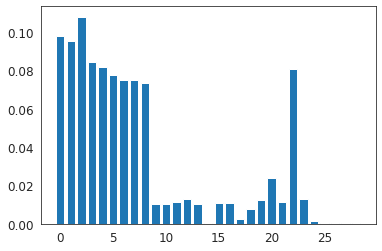

In [84]:
# Using feature importance

importance = final_model_rfc.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.3f' % (i,v))

# print the sorted list of the top 9 features
sorted_list = sorted(importance, reverse=True)
print('\nScores of the top 9 features:\n', sorted_list[0:9])

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

9 most important features in order to predict default payment are:
1) graduate
2) male
3) bill
4) female
5) undergraduate
6) high school
7) others
8) single
9) married

**Note:**<br>
RFE and feature_importance methods give the same top 9 features which is nice.

**(iii) Using permutation importance - Sorry I couldn't make the codes work sadly**

In [85]:
'''
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric(model, X_train, y_train)
    importance = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(model, X_train, y_train)
        X_train[col] = save
        importance.append(baseline - m)
    return np.array(importance)
    '''

'\ndef permutation_importances(model, X_train, y_train, metric):\n    baseline = metric(model, X_train, y_train)\n    importance = []\n    for col in X_train.columns:\n        save = X_train[col].copy()\n        X_train[col] = np.random.permutation(X_train[col])\n        m = metric(model, X_train, y_train)\n        X_train[col] = save\n        importance.append(baseline - m)\n    return np.array(importance)\n    '

In [86]:
'''
def _get_unsampled_indices(tree, n_samples):
    """
    An interface to get unsampled indices regardless of sklearn version.
    """
    from sklearn.ensemble._forest import _get_n_samples_bootstrap
    n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
    #_generate_unsampled_indices = test(tree.random_state, n_samples, n_samples_bootstrap)
    #return _generate_unsampled_indices
    return n_samples_bootstrap
'''

'\ndef _get_unsampled_indices(tree, n_samples):\n    """\n    An interface to get unsampled indices regardless of sklearn version.\n    """\n    from sklearn.ensemble._forest import _get_n_samples_bootstrap\n    n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)\n    #_generate_unsampled_indices = test(tree.random_state, n_samples, n_samples_bootstrap)\n    #return _generate_unsampled_indices\n    return n_samples_bootstrap\n'

In [87]:
#_get_unsampled_indices = _get_unsampled_indices(final_model_rfc.estimators_, len(X_train_trans))

In [88]:
'''
def oob_classifier_accuracy(model, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X1 = X_train#.values
    y1 = y_train.values

    n_samples = len(X1)
    n_classes = len(np.unique(y1))
    predictions = np.zeros((n_samples, n_classes))
    for tree in model.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict_proba(X1[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [model.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y1 == predicted_classes)
    return oob_score
'''

'\ndef oob_classifier_accuracy(model, X_train, y_train):\n    """\n    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest\n    classifier. We learned the guts of scikit\'s RF from the BSD licensed\n    code:\n    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425\n    """\n    X1 = X_train#.values\n    y1 = y_train.values\n\n    n_samples = len(X1)\n    n_classes = len(np.unique(y1))\n    predictions = np.zeros((n_samples, n_classes))\n    for tree in model.estimators_:\n        unsampled_indices = _get_unsampled_indices(tree, n_samples)\n        tree_preds = tree.predict_proba(X1[unsampled_indices, :])\n        predictions[unsampled_indices] += tree_preds\n\n    predicted_class_indexes = np.argmax(predictions, axis=1)\n    predicted_classes = [model.classes_[i] for i in predicted_class_indexes]\n\n    oob_score = np.mean(y1 == predicted_classes)\n    return oob_score\n'

In [89]:
#oob_classifier_accuracy = oob_classifier_accuracy(final_model_rfc, X_train_trans, y_train)
# importance = permutation_importances(final_model_rfc, X_train_trans, y_train, oob_classifier_accuracy)

In [90]:
'''
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I
'''

"\ndef dropcol_importances(rf, X_train, y_train):\n    rf_ = clone(rf)\n    rf_.random_state = 999\n    rf_.fit(X_train, y_train)\n    baseline = rf_.oob_score_\n    imp = []\n    for col in X_train.columns:\n        X = X_train.drop(col, axis=1)\n        rf_ = clone(rf)\n        rf_.random_state = 999\n        rf_.fit(X, y_train)\n        o = rf_.oob_score_\n        imp.append(baseline - o)\n    imp = np.array(imp)\n    I = pd.DataFrame(\n            data={'Feature':X_train.columns,\n                  'Importance':imp})\n    I = I.set_index('Feature')\n    I = I.sort_values('Importance', ascending=True)\n    return I\n"

## Best threshold value

While the ROC curve (TPR vs FPR) itself might be useful to let you see the tradeoff between TPR and FPR, it's not very convenient to choose the exact value for the probability threshold. One method is to calculate Youden's J or to plot the TPR and FPR against different thresholds (from 0 to 1).

**(i) Youden's J**

In [91]:
from numpy import argmax

# Predicted y using final model
y_proba = cross_val_predict(final_model_rfc, X_train_trans, y_train, cv=5, method='predict_proba') 

# Determine scores from probabilities
y_score = y_proba[:, 1] 

# Compute FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_score)

# Calculate Youden's J
J = tpr - fpr
ix = argmax(J)
best_threshold_J = thresholds[ix]
print('Best threshold according to Youden J >>> %.2f' % (best_threshold_J))

Best threshold according to Youden J >>> 0.28


**(ii) F1 score**

In [92]:
from numpy import arange
from numpy import argmax

# Predicted y using final model
y_proba = cross_val_predict(final_model_rfc, X_train_trans, y_train, cv=5, method='predict_proba') 
y_score = y_proba[:, 1] 


# apply threshold to positive probabilities to create labels
def to_labels(y_score, threshold):
    return (y_score >= threshold).astype('int')

# define thresholds
thresholds = arange(0, 1, 0.001)

# Call the function to evaluate each threshold
scores = [f1_score(y_true=y_train, y_pred=to_labels(y_score, t)) for t in thresholds]

# get best threshold according to best F1 score
ix = argmax(scores)

best_threshold_f1 = thresholds[ix]

print('Best threshold according to F1 score >>> %.2f with F1-Score = %.2f' % (best_threshold_f1, scores[ix]))

Best threshold according to F1 score >>> 0.34 with F1-Score = 0.51


**Print both thresholds on the probabilities for positive class curve**

In [93]:
def calculate_tp_tn_fp_fn(y_true, predict_proba, threshold=0.5):
    from sklearn.metrics import confusion_matrix
    predict_adjusted = np.int_(predict_proba>threshold)
    cm=confusion_matrix(y_true, predict_adjusted)
    tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
    return tp, tn, fp, fn

def calculate_tpr_fpr_vs_threshold(y_true, predict_proba, steps):
    probability_thresholds = np.linspace(0, 1, steps)
    tpr_list = [0]*steps
    fpr_list = [0]*steps
    for i, val in enumerate(probability_thresholds):
        tp, tn, fp, fn = calculate_tp_tn_fp_fn(y_true, predict_proba, val)
        tpr_list[i] = tp/(tp+fn)
        fpr_list[i] = fp/(fp+tn)
    return tpr_list, fpr_list, probability_thresholds

def plot_tpr_fpr_vs_threshold(model, X_train, y_train, steps=100):
    from sklearn.model_selection import cross_val_predict
    #y_proba = cross_val_predict(model, X_train, y_train, cv=cv, method="predict_proba")
    y_proba = model.predict_proba(X=X_train)
    y_scores = y_proba[:,1]
    tpr, fpr, thresholds = calculate_tpr_fpr_vs_threshold(y_train, y_scores, steps)
    plt.plot(thresholds, tpr, "b-", label="TPR", linewidth=2)
    plt.plot(thresholds, fpr, "y-", label="FPR", linewidth=2)
    plt.xlabel("Probability threshold for positive class", fontsize=16)
    plt.legend(loc="best", fontsize=15, frameon=True, facecolor=(0,0,0,0.4), framealpha=0.4)
    plt.ylim([0, 1])

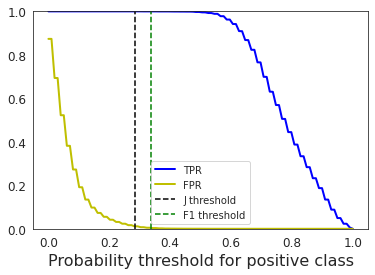

In [94]:
# Call the function for RFC
plot_tpr_fpr_vs_threshold(final_model_rfc, X_train_trans, y_train)

# Plot Youden's J best threshold
plt.axvline(x=best_threshold_J, linestyle='--', color='black', label='J threshold')
plt.legend()

# Plot F1 score best threshold
plt.axvline(x=best_threshold_f1, linestyle='--', color='green', label='F1 threshold')
plt.legend()

**Note:**<br>
Both thresholds are really close to each other however according to the graph, it seems like the F1 threshold would be a slighly better choice.

**Find Precision and Recall values at F1 best threshold**

In [95]:
from sklearn.metrics import precision_recall_curve

# Predicted probabilities using final model
y_proba = cross_val_predict(final_model_rfc, X_train_trans, y_train, cv=5, method='predict_proba') 

# Determine scores from probabilities
y_score = y_proba[:, 1] 


# Compute Precision-Recall for different threshold values using training set
precision, recall, threshold = precision_recall_curve(y_true=y_train, probas_pred=y_score)

# Determine Precision at F1 best threshold
precision_best_threshold = precision[np.argmax(threshold >= best_threshold_f1)] # first index of the maximum value
print('Precision at best threshold >>> %.2f' % (precision_best_threshold))

# Determine Recall at F1 best threshold
recall_best_threshold = recall[np.argmax(threshold >= best_threshold_f1)]
print('Recall at best threshold >>> %.2f' % (recall_best_threshold))


Precision at best threshold >>> 0.52
Recall at best threshold >>> 0.50


**Plot Precision and Recall as a function of the threshold**

In [96]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
   
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
    # Plot best threshold
    plt.axvline(x=best_threshold_f1, linestyle='--', color='red', label='F1 best threshold')
    
    # Settings
    plt.ylabel("Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')
    plt.show()

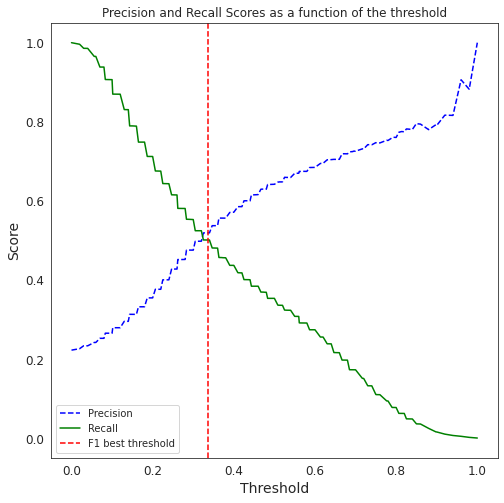

In [97]:
# Call the function for RFC
plot_precision_recall_vs_threshold(precision, recall, threshold)

## Final Model characteristics

> Classifier >> RandomForestClassifier<br>

> Best hyperparameters:<br>
        - n_estimators = 50<br>
        - max_features = 9

> Best threshold = 0.34

> Top 9 features in order to predict default payment are:<br>
    > 1) graduate school
    > 2) male
    > 3) amount of bill statement
    > 4) female
    > 5) university
    > 6) high school
    > 7) others
    > 8) single
    > 9) married

# 7) Evaluate the Final Model on Test set

In [98]:
# Final model
final_model_rfc = gs_rfc.best_estimator_

# Define test set
X_test
y_test

# Apply pipeline to test set by calling transform (not fit_transform)
X_test_trans = full_pipeline.transform(X_test)

print(f"X_test_trans shape: {X_test_trans.shape}")

X_test_trans shape: (5914, 29)


**(i) Performance Measures comparison between the train and test sets for the final model**

In [104]:
# Accuracy
print('Accuracy_train:', round(cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='accuracy').mean()*100, 2), '%')
print('Accuracy_test:', round(cross_val_score(final_model_rfc, X_test_trans, y_test, cv=5, scoring='accuracy').mean()*100, 2), '%')


# Precision
print('\nPrecision_train: %.2f' % (cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='precision').mean()))
print('Precision_test: %.2f' % (cross_val_score(final_model_rfc, X_test_trans, y_test, cv=5, scoring='precision').mean()))


# Recall
print('\nRecall_train: %.2f' % (cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='recall').mean()))
print('Recall_test: %.2f' % (cross_val_score(final_model_rfc, X_test_trans, y_test, cv=5, scoring='recall').mean()))


# F1 score
print('\nF1 score_train: %.2f' % (cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='f1').mean()))
print('F1 score_test: %.2f' % (cross_val_score(final_model_rfc, X_test_trans, y_test, cv=5, scoring='f1').mean()))


# ROC AUC
print('\nROC AUC_train: %.2f' % (cross_val_score(final_model_rfc, X_train_trans, y_train, cv=5, scoring='roc_auc').mean()))
print('ROC AUC_test: %.2f' % (cross_val_score(final_model_rfc, X_test_trans, y_test, cv=5, scoring='roc_auc').mean()))


Accuracy_train: 81.31 %
Accuracy_test: 80.83 %

Precision_train: 0.66
Precision_test: 0.65

Recall_train: 0.34
Recall_test: 0.34

F1 score_train: 0.45
F1 score_test: 0.44

ROC AUC_train: 0.75
ROC AUC_test: 0.75


**Note:**<br>
It looks like the training set and the test sets are performing just as good. This is good news and suggest no under- of over-fitting the training set.

**(ii) Performance Measures comparison between the default threshold and the best threshold using test sets with the final model**

In [100]:
# Define a function to use the best threshold
    # Convert probabilities >= threshold to positive class "1" and the others to "0"

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [101]:
# Predict the probabilities for the classes
y_proba_test = cross_val_predict(final_model_rfc, X_test_trans, y_test, cv=5, method='predict_proba')
y_score_test = y_proba_test[:,1]

In [102]:
# Call the function to convert probabilities >= best F1 threshold to positive class "1"
y_hat_thres_f1 = adjusted_classes(y_score_test, best_threshold_f1)

# Call the function to convert probabilities >= best Youden J threshold to positive class "1"
y_hat_thres_J = adjusted_classes(y_score_test, best_threshold_J)

# Predicted y (y_hat) with default threshold
y_hat_thres_d = cross_val_predict(final_model_rfc, X_test_trans, y_test, cv=5, method='predict')
#y_hat_default_thres_test = adjusted_classes(y_score_test, 0.50)

In [103]:
# Print Performance metrics for the default threshold=0.50 and the custom best thresholds


# Accuracy
print('Accuracy_default: %.2f' % (accuracy_score(y_true=y_test, y_pred=y_hat_thres_d)*100), '%')
print('Accuracy_custom_F1: %.2f' % (accuracy_score(y_true=y_test, y_pred=y_hat_thres_f1)*100), '%') 
print('Accuracy_custom_J: %.2f' % (accuracy_score(y_true=y_test, y_pred=y_hat_thres_J)*100), '%') 

# Precision
print('\nPrecision_default: %.2f' % precision_score(y_true=y_test, y_pred=y_hat_thres_d))
print('Precision_custom_F1: %.2f' % precision_score(y_true=y_test, y_pred=y_hat_thres_f1))
print('Precision_custom_J: %.2f' % precision_score(y_true=y_test, y_pred=y_hat_thres_J))

# Recall
print('\nRecall_default: %.2f' % recall_score(y_true=y_test, y_pred=y_hat_thres_d))
print('Recall_custom_F1: %.2f' % recall_score(y_true=y_test, y_pred=y_hat_thres_f1))
print('Recall_custom_J: %.2f' % recall_score(y_true=y_test, y_pred=y_hat_thres_J))

# F1 score
print('\nF1 score_default: %.2f' % f1_score(y_true=y_test, y_pred=y_hat_thres_d))
print('F1 score_custom_F1: %.2f' % f1_score(y_true=y_test, y_pred=y_hat_thres_f1))
print('F1 score_custom_J: %.2f' % f1_score(y_true=y_test, y_pred=y_hat_thres_J))

Accuracy_default: 81.11 %
Accuracy_custom_F1: 78.24 %
Accuracy_custom_J: 75.85 %

Precision_default: 0.65
Precision_custom_F1: 0.51
Precision_custom_J: 0.47

Recall_default: 0.33
Recall_custom_F1: 0.52
Recall_custom_J: 0.57

F1 score_default: 0.44
F1 score_custom_F1: 0.52
F1 score_custom_J: 0.51


**Note**<br>
It is interesting to note that we could pick different threshold values according to the performance measure the most important to answer our question. <br>
At the beginning we determined that we would look at all performance metrics but we would prefer the F1 score over accuracy. <br>
Based on that, we should choose the threshold of 0.31 that gives the highest F1 score.

# 8) Conclusions

1) RandomForestClassifier performed slightly better on the training set than KNeighborsClassifier and it's the reason why it was chosen. Performance measures using the training set and test sets for the final model are:


|  | Before tuning<br>(training set) | After tuning<br>(training set) | After tuning<br>(test set) |
| :- | -: | -: | :-: |
| Accuracy | 81.4 | 81.2 | 81.0
| Precision | .65 | .65 | .65
| Recall | .34 | .35 | .34
| F1 score | .45 | .45 | .44
| ROC AUC | .75 | .75 | .75
            

2) The final model was fine tuned by searching the best combination or hyperparameters and the results were:
            n_estimators = 50
            max_features = 9


3) The best threshold value of 0.33 was chosen based on maximizing the F1 score.


4) Top 9 features in order to predict default payment are:

            graduate school
            male
            amount of bill statement
            female
            university
            high school
            others
            single
            married